#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/csl.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df_stock3 = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock3.iloc[:-1,:]
# Drop last 3 columns sentiment RBA FED
N=3
df = df_stock_less1.iloc[: , :-N]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/01/2000,7.300000,7.300000,7.300000,7.300000,5.234562,0.0
1,4/01/2000,7.333333,7.333333,7.066666,7.186666,5.153295,254295.0
2,5/01/2000,7.000000,7.183333,7.000000,7.155000,5.130589,424941.0
3,6/01/2000,7.233333,7.273333,7.000000,7.000000,5.019443,348534.0
4,7/01/2000,7.013000,7.023333,6.800000,6.850000,4.911883,483963.0


<AxesSubplot:>

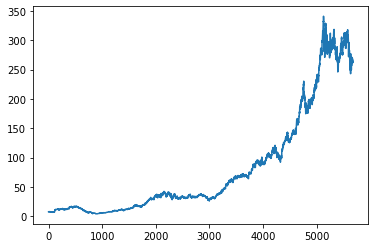

In [3]:
df["Close"].plot()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5643 entries, 0 to 5677
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5643 non-null   object 
 1   Open       5643 non-null   float64
 2   High       5643 non-null   float64
 3   Low        5643 non-null   float64
 4   Close      5643 non-null   float64
 5   Adj Close  5643 non-null   float64
 6   Volume     5643 non-null   float64
dtypes: float64(6), object(1)
memory usage: 352.7+ KB


In [5]:
data = df.filter(['Close'])
dataset = data.values
dataset.shape


(5643, 1)

# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [6]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4515, 1)

In [7]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.01017412, 0.00983794, 0.00974402, 0.00928425, 0.00883932,
       0.01027299, 0.01022355, 0.01047074, 0.01037186, 0.01072781,
       0.01096511, 0.01091567, 0.01096511, 0.01141004, 0.01101454,
       0.01086623, 0.01081581, 0.01145948, 0.01126173, 0.01135368,
       0.01145948, 0.01150891, 0.01154846, 0.01155835, 0.01160779,
       0.01096511, 0.01111342, 0.01126173, 0.01056961, 0.01041141,
       0.01037186, 0.01003569, 0.00937719, 0.00899653, 0.00903707,
       0.00898763, 0.00898763, 0.00943256, 0.00933369, 0.009482  ,
       0.01007524, 0.00999515, 0.009482  , 0.00862773, 0.00918538,
       0.00928425, 0.00898763, 0.00903707, 0.0097806 , 0.00997637,
       0.00997637, 0.00997637, 0.01037186, 0.01032243, 0.01039362,
       0.01056961, 0.01066848, 0.01047074, 0.01027299, 0.01047074])]
[0.010477658470026397]


# Prepare train data for LSTM model

In [8]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4455, 60)

In [9]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4455, 60, 1)

# Build the LSTM model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4455/4455 [==============================] - 54s 12ms/step - loss: 2.1424e-04


In [13]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [14]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [15]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [16]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

9.474548126251007

C:\Users\antoi\AppData\Local\Temp/ipykernel_4208/2718277095.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


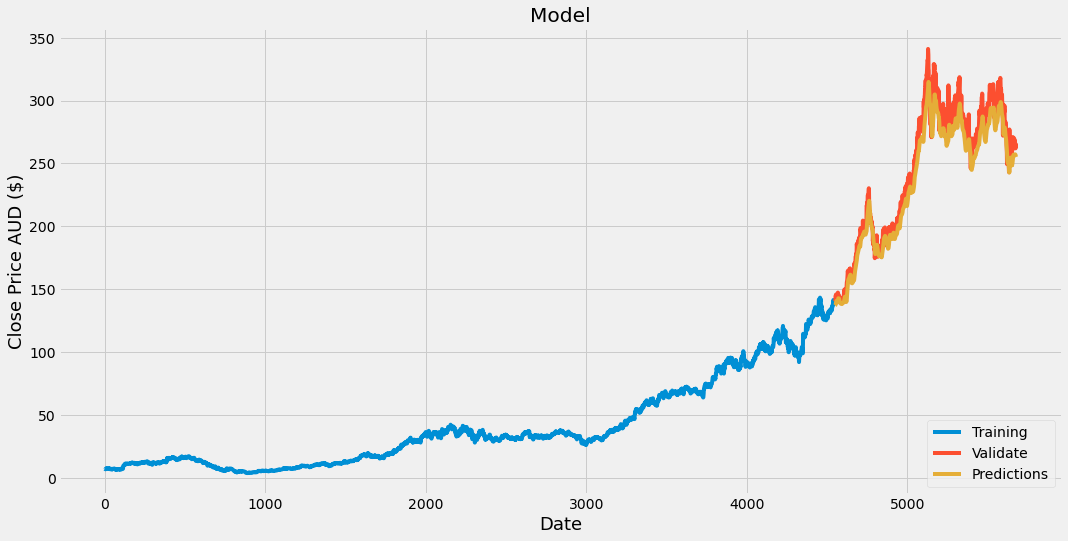

In [17]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Predictions'],loc='lower right')
plt.show()


# Test data Predictions on the Model

In [18]:
valid['Difference']= valid['Close']-valid['Predictions']
valid

C:\Users\antoi\AppData\Local\Temp/ipykernel_4208/3952761259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


,Close,Predictions,Difference
4550,140.419998,137.059723,3.360275
4551,140.990005,137.151047,3.838958
4552,143.020004,137.327057,5.692947
4553,144.589996,137.752136,6.837860
4554,144.270004,138.419968,5.850036
...,...,...,...
5673,265.470001,257.080536,8.389465
5674,261.970001,256.820862,5.149139
5675,262.959991,256.154907,6.805084
5676,264.950012,255.524689,9.425323


In [19]:
#Get latest 60 quotes less 1 to predict:

#import pandas_datareader.data as web
#symbol = 'CSL.AX'
#stock_quote = web.DataReader(symbol,data_source='yahoo',start='2022-01-01', end='2022-04-13')
#stock_quotes_sixty = stock_quotes_sixty.filter(['Close'])
#stock_quotes_sixty
#OR

stock_quotes_sixty = df_stock_less1.tail(60)
stock_close_sixty = stock_quotes_sixty['Close']


In [20]:
# Use last 60 days price on model to predict next days price
last_60_days = stock_close_sixty[-60:].values
last_60_days = last_60_days.reshape(-1,1)
last_60_days_scaled = scaler.transform(last_60_days)

In [21]:
X_test = []
X_test.append(last_60_days_scaled)
X_test =np.array(X_test)
X_test =np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price = int(pred_price)
print(f'Predicted next day share price {pred_price}')

Predicted next day share price 254


In [22]:
#stock_quote_acual = web.DataReader('CSL.AX',data_source='yahoo',start='2022-04-14', end='2022-04-14')
#OR get last quote from latest csv
stock_quote_last_one = df_stock1.tail(1)
stock_quote_last_one


,Date,Open,High,Low,Close,Adj Close,Volume,SENTIMENT,RBA,FED
5678,20/04/2022,266.100006,267.98999,263.700012,264.5,264.5,857150.0,NEGATIVE,0.05,0.08


In [23]:
#save actual to variable
actual_price = stock_quote_last_one.iloc[0,4]
actual_date = stock_quote_last_one.iloc[0,0] 
actual_price = int(actual_price)
actual_price
actual_date


'20/04/2022'

# Save the Model

In [24]:
import joblib
filename = 'cslmodel.sav'
#joblib.dump(model, filename)

#Save predicted price to MongoDB

In [25]:
# Module used to connect Python with MongoDb
import pymongo

In [26]:
# The default port used by MongoDB is 27017
# https://docs.mongodb.com/manual/reference/default-mongodb-port/
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

# Define the 'sharesDB' database in Mongo
db = client.sharesDB

In [27]:
# Query all
# Here, db.companys refers to the collection 'companys '
companys = db.companys.find()

# Iterate through each company in the collection
for company in companys:
    print(company)

{'_id': ObjectId('6264fbd42e2e09a809a86cac'), 'model': 'LSTM', 'name': 'CBA', 'date': '14/04/2022', 'predicted': 100, 'actual': 106, 'differece': -6}
{'_id': ObjectId('6264ff16df07389eadcbc16d'), 'model': 'LSTM', 'name': 'BHP', 'date': '14/04/2022', 'predicted': 47, 'actual': 52, 'differece': -5}
{'_id': ObjectId('626501370c82845407aeb22d'), 'model': 'LSTM', 'name': 'NAB', 'date': '14/04/2022', 'predicted': 33, 'actual': 32, 'differece': 1}


In [28]:
# Set keys and values of company
name = 'CSL'
predicted = int(pred_price)
difference = pred_price-actual_price
print(f'date {actual_date},predicted {predicted},actual {actual_price}, difference {difference}')

date 20/04/2022,predicted 254,actual 264, difference -10


In [29]:
# Insert a document into the 'companys' collection
db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': actual_date,
      'predicted': predicted,
      'actual': actual_price,
      'differece': difference
    }
)

# query the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('6264fbd42e2e09a809a86cac'), 'model': 'LSTM', 'name': 'CBA', 'date': '14/04/2022', 'predicted': 100, 'actual': 106, 'differece': -6}
{'_id': ObjectId('6264ff16df07389eadcbc16d'), 'model': 'LSTM', 'name': 'BHP', 'date': '14/04/2022', 'predicted': 47, 'actual': 52, 'differece': -5}
{'_id': ObjectId('626501370c82845407aeb22d'), 'model': 'LSTM', 'name': 'NAB', 'date': '14/04/2022', 'predicted': 33, 'actual': 32, 'differece': 1}
{'_id': ObjectId('6265026f632b6c5eed85b5c5'), 'model': 'LSTM', 'name': 'CSL', 'date': '20/04/2022', 'predicted': 254, 'actual': 264, 'differece': -10}


In [30]:
# # Delete a document from a collection
# db.companys.delete_one(
#     {'name': 'CSL'}
# )

# # query the companys collection
# companys = db.companys.find()

# # see change in the collection
# for company in companys:
#     print(company)